What is the purpose of this? 

This model is meant to show that the use of the csvs metric on blinded typical data can be used to predict how a model perfoms on truly cold start examples (pharos)

Trying to show that:

- Deviation behavior on blinded data (CSVS) can be quantified

- The behavior generalizes — can predict model errors on cold-start samples as a whole (model level)

- So CSVS can act as a model evaluation tool even when no Pharos-type cold-start labels are available

little lost... Should i be using true affinity to predict on... depends on if pred model or indiv

Pred model

If i was making this model for real use then the user would want to be able to pass in just the drug and protein bc i may not have the affinity for a pair BUT they could have the predicted affinity

but this is also just to show that csvs can be a good eval tool for a models cold start vulnerability so 


In [19]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
from scipy.spatial import ConvexHull, Delaunay

# === File paths ===
unblinded_file = "1000EPOCH/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "1000EPOCH/concatenated_final_test_predictions.csv"
pharos_file = "1000EPOCH/pharos_test_predictions_GINConvNet.csv"

# === Load and format datasets ===
df_unblinded = pd.read_csv(unblinded_file).rename(columns={
    "True_Label": "True",
    "Predicted_Value": "Prediction"
})

df_blinded = pd.read_csv(blinded_file).rename(columns={
    "True_Label": "True",
    "Predicted_Value": "Prediction"
})

df_pharos = pd.read_csv(pharos_file).rename(columns={
    "True_Label": "True",
    "Predicted_Value": "Prediction"
})


# === Function to compute deltas using convex hull ===

def compute_directional_deltas(unblinded_df, blinded_df):
    """
    Computes directional deviation vectors (delta_x, delta_y) from each blinded point
    to the convex hull of unblinded points (in True vs Prediction space).
    Works for both points inside and outside the hull.
    """
    unblinded = unblinded_df[["True", "Prediction"]].values
    blinded = blinded_df[["True", "Prediction"]].values

    if len(unblinded) < 3:
        raise ValueError("Need at least 3 unblinded points.")

    # Compute convex hull and geometric tools
    hull = ConvexHull(unblinded)
    hull_points = unblinded[hull.vertices]
    boundary = LineString(hull_points.tolist() + [hull_points[0].tolist()])
    delaunay = Delaunay(hull_points)

    delta_x = np.zeros(len(blinded))
    delta_y = np.zeros(len(blinded))
    inside_mask = delaunay.find_simplex(blinded) >= 0

    for i, point_coords in enumerate(blinded):
        pt = Point(point_coords)
        nearest = nearest_points(pt, boundary)[1]
        vec = np.array(point_coords) - np.array([nearest.x, nearest.y])
        delta_x[i] = vec[0]
        delta_y[i] = vec[1]

    # Return result
    result_df = blinded_df.copy()
    result_df["delta_x"] = delta_x
    result_df["delta_y"] = delta_y
    result_df["outside_hull"] = ~inside_mask
    return result_df

# === Apply delta computation ===
df_blinded_with_deltas = compute_directional_deltas(df_unblinded, df_blinded)
df_pharos_with_deltas = compute_directional_deltas(df_unblinded, df_pharos)



In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import numpy as np

# === 1. Prepare Features and Targets from df_blinded_with_deltas ===

# Rename for convenience
df = df_blinded_with_deltas.copy()

# Make sure column names match exactly:
df = df.rename(columns={
    "Protein_ID": "protein",
    "Drug_ID": "drug",
    "True": "affinity"  # treat true affinity as input feature
})

# Feature matrix X and target matrix y
X = df[["protein", "drug", "affinity"]]
y = df[["delta_x", "delta_y"]]

# === 2. Preprocessor for categorical variables ===
preprocessor = ColumnTransformer([
    ("protein", OneHotEncoder(handle_unknown='ignore'), ["protein"]),
    ("drug", OneHotEncoder(handle_unknown='ignore'), ["drug"])
], remainder="passthrough")  # 'affinity' is passed through

# === 3. Train Mean Deviation Model (Δx, Δy) ===
mean_model = make_pipeline(preprocessor, MultiOutputRegressor(GradientBoostingRegressor()))
mean_model.fit(X, y)

# === 4. Predict on Training Data to Estimate Residual Variance ===
y_pred = mean_model.predict(X)
residuals = y.values - y_pred
squared_residuals = residuals**2

# === 5. Train Variance Model on Squared Residuals ===
var_model = make_pipeline(preprocessor, MultiOutputRegressor(GradientBoostingRegressor()))
var_model.fit(X, squared_residuals)


/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('protein',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protein']),
                                                 ('drug',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['drug'])])),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=GradientBoostingRegressor()))])

In [ ]:
df_pharos_with_deltas = df_pharos_with_deltas.rename(columns={
    "Protein_ID": "protein",
    "Drug_ID": "drug",
    "True": "affinity"  # treat true affinity as input feature
})
X_test = df_pharos_with_deltas[["protein", "drug", "affinity"]]

# Predict mean and variance
mean_pred = mean_model.predict(X_test)         # shape (N, 2)
var_pred = var_model.predict(X_test)           # shape (N, 2)


df_pharos_with_deltas["pred_delta_x"] = mean_pred[:, 0]
df_pharos_with_deltas["pred_delta_y"] = mean_pred[:, 1]
df_pharos_with_deltas["pred_var_x"] = var_pred[:, 0]
df_pharos_with_deltas["pred_var_y"] = var_pred[:, 1]


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_55988/1713789146.py:12: RuntimeWarning: invalid value encountered in sqrt
  width=2 * np.sqrt(row["pred_var_x"]),
/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_55988/1713789146.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse((row["pred_delta_x"], row["pred_delta_y"]),


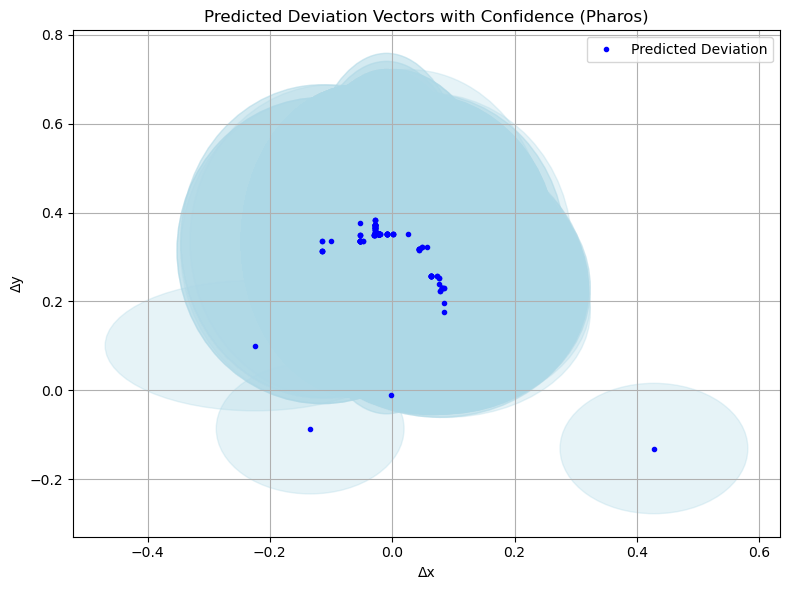

In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(8, 6))

pharos_sample = df_pharos_with_deltas  # or .sample(N) if it's large

# Plot predicted deviation points and ellipses
for i, row in pharos_sample.iterrows():
    # 1-sigma ellipse around predicted deviation
    ellipse = Ellipse((row["pred_delta_x"], row["pred_delta_y"]),
                      width=2 * np.sqrt(row["pred_var_x"]),
                      height=2 * np.sqrt(row["pred_var_y"]),
                      alpha=0.3, color='lightblue', edgecolor='blue')
    ax.add_patch(ellipse)

    # Plot predicted deviation point
    ax.plot(row["pred_delta_x"], row["pred_delta_y"], 'bo', markersize=3,
            label='Predicted Deviation' if i == pharos_sample.index[0] else "")

# Final touches
ax.set_xlabel("Δx")
ax.set_ylabel("Δy")
ax.set_title("Predicted Deviation Vectors with Confidence (Pharos)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_55988/2912834942.py:16: RuntimeWarning: invalid value encountered in sqrt
  width=2 * np.sqrt(row["pred_var_x"]),
/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_55988/2912834942.py:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse((row["pred_delta_x"], row["pred_delta_y"]),


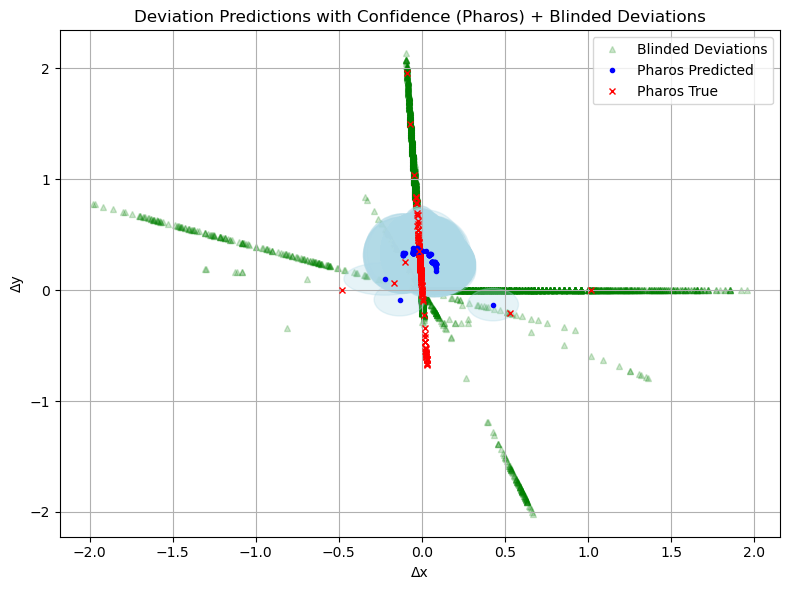

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(8, 6))

# Sample a small set for clarity
pharos_sample = df_pharos_with_deltas
blinded_sample = df_blinded_with_deltas

ax.plot(blinded_sample["delta_x"], blinded_sample["delta_y"],
        'g^', alpha=0.2, markersize=4, label='Blinded Deviations', zorder=1)

# === Plot PHAROS prediction ellipses and points ===
for _, row in pharos_sample.iterrows():
    ellipse = Ellipse((row["pred_delta_x"], row["pred_delta_y"]),
                      width=2 * np.sqrt(row["pred_var_x"]),
                      height=2 * np.sqrt(row["pred_var_y"]),
                      alpha=0.3, color='lightblue', edgecolor='blue')
    ax.add_patch(ellipse)
    ax.plot(row["pred_delta_x"], row["pred_delta_y"], 'bo', markersize=3, label='Pharos Predicted' if _ == pharos_sample.index[0] else "")
    ax.plot(row["delta_x"], row["delta_y"], 'rx', markersize=5, label='Pharos True' if _ == pharos_sample.index[0] else "")


# === Labels and formatting ===
ax.set_xlabel("Δx")
ax.set_ylabel("Δy")
ax.set_title("Deviation Predictions with Confidence (Pharos) + Blinded Deviations")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_55988/2843330636.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(df))


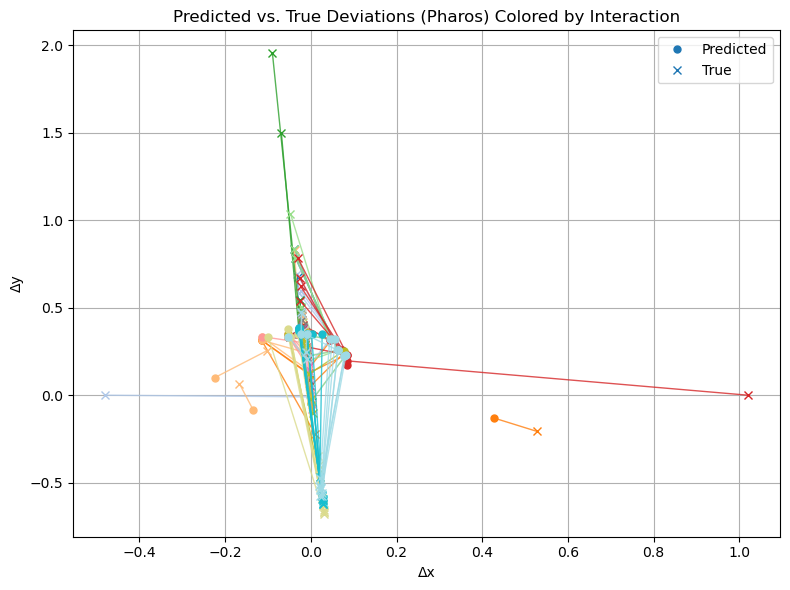

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Sample to reduce clutter if needed
df = df_pharos_with_deltas  # adjust as needed

fig, ax = plt.subplots(figsize=(8, 6))

# Generate distinct colors
colors = cm.get_cmap('tab20', len(df))

for i, row in enumerate(df.itertuples()):
    pred = (row.pred_delta_x, row.pred_delta_y)
    true = (row.delta_x, row.delta_y)

    # Line from prediction to truth
    ax.plot([pred[0], true[0]], [pred[1], true[1]],
            color=colors(i), alpha=0.8, linewidth=1)

    # Dots for predicted and true points
    ax.plot(pred[0], pred[1], 'o', color=colors(i), markersize=5, label='Predicted' if i == 0 else "")
    ax.plot(true[0], true[1], 'x', color=colors(i), markersize=6, label='True' if i == 0 else "")

ax.set_xlabel("Δx")
ax.set_ylabel("Δy")
ax.set_title("Predicted vs. True Deviations (Pharos) Colored by Interaction")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


Now using embeddings

In [10]:
import pandas as pd

# Load DAVIS drug and protein sequences
davis_drugs = pd.read_csv("davis_b3_drugs.csv")
davis_prots = pd.read_csv("davis_b3_prots.csv")

# Load PHAROS sequences (already matched)
pharos_df = pd.read_csv("pharos_with_ids.csv")

# Build dictionaries (combine DAVIS + PHAROS)
drug_smiles_dict = pd.concat([
    davis_drugs.rename(columns={"drug_id": "drug", "drug_seq": "smiles"})[["drug", "smiles"]],
    pharos_df.rename(columns={"drug_id": "drug", "drug_smile": "smiles"})[["drug", "smiles"]]
]).drop_duplicates("drug").set_index("drug")["smiles"].to_dict()

protein_seq_dict = pd.concat([
    davis_prots.rename(columns={"prot_id": "protein", "prot_seq": "sequence"}),
    pharos_df.rename(columns={"prot_id": "protein", "prot_seq": "sequence"})
])[["protein", "sequence"]].drop_duplicates("protein").set_index("protein")["sequence"].to_dict()


In [11]:
import esm
import torch
import numpy as np
from tqdm import tqdm

# Load ESM-1b model (no CUDA)
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
model.eval()  # no .cuda()

batch_converter = alphabet.get_batch_converter()

# Prepare your protein data: list of (protein_id, sequence[:1022])
protein_data = [(pid, seq[:1022]) for pid, seq in protein_seq_dict.items()]

# Store embeddings
protein_embeddings = {}

# Loop through one at a time (safe on CPU)
for pid, seq in tqdm(protein_data):
    batch_labels, batch_strs, batch_tokens = batch_converter([(pid, seq)])

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=False)

    token_reps = results["representations"][33][0]  # shape: (seq_len+2, hidden_dim)
    mean_rep = token_reps[1:len(seq)+1].mean(0).numpy()  # exclude CLS and EOS
    protein_embeddings[pid] = mean_rep


python(61506) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 470/470 [16:45<00:00,  2.14s/it]


In [33]:
import pickle
with open("esm1b_protein_embeddings.pkl", "wb") as f:
    pickle.dump(protein_embeddings, f)

In [25]:
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence
from rdkit import Chem
import numpy as np

# Load pretrained Mol2Vec model
mol2vec_model = word2vec.Word2Vec.load("model_300dim.pkl")

drug_embeddings = {}
embedding_dim = 300

for drug_id, smiles in tqdm(drug_smiles_dict.items()):
    try:
        mol = Chem.MolFromSmiles(smiles)
        sentence = mol2alt_sentence(mol, radius=2)
        emb = np.sum([mol2vec_model.wv.get(w, mol2vec_model.wv["UNK"]) for w in sentence], axis=0)
        drug_embeddings[drug_id] = emb
    except:
        drug_embeddings[drug_id] = np.zeros(embedding_dim)


  0%|          | 0/277 [00:00<?, ?it/s][11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPRECATION WARNING: please use MorganGenerator
[11:27:15] DEPREC

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import pandas as pd

# Copy and rename columns
df_emb = df_blinded_with_deltas.copy().rename(columns={
    "Protein_ID": "protein",
    "Drug_ID": "drug",
    "True": "affinity"
})

# === Embedding application ===
def apply_embedding(df, id_col, embedding_dict, prefix):
    emb_size = len(next(iter(embedding_dict.values())))
    emb_cols = [f"{prefix}_emb_{i}" for i in range(emb_size)]
    emb_array = np.stack([embedding_dict.get(pid, np.zeros(emb_size)) for pid in df[id_col]])
    emb_df = pd.DataFrame(emb_array, columns=emb_cols, index=df.index)
    return pd.concat([df, emb_df], axis=1)

df_emb = apply_embedding(df_emb, "protein", protein_embeddings, prefix="protein")
df_emb = apply_embedding(df_emb, "drug", drug_embeddings, prefix="drug")

# === Feature matrix and targets ===
feature_cols = ["affinity"] + [col for col in df_emb.columns if col.startswith("protein_emb_") or col.startswith("drug_emb_")]
X_emb = df_emb[feature_cols]
y_emb = df_emb[["delta_x", "delta_y"]]

# === Mean model ===
mean_model_emb = make_pipeline(
    StandardScaler(),  # Scaling numeric + embedding features
    MultiOutputRegressor(GradientBoostingRegressor())
)
mean_model_emb.fit(X_emb, y_emb)

# === Residual variance model ===
y_pred_emb = mean_model_emb.predict(X_emb)
residuals_emb = y_emb.values - y_pred_emb
squared_residuals_emb = residuals_emb**2

var_model_emb = make_pipeline(
    StandardScaler(),  # Same scale assumptions
    MultiOutputRegressor(GradientBoostingRegressor(n_estimators=300, max_depth=5))
)
var_model_emb.fit(X_emb, squared_residuals_emb)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=5,
                                                                          n_estimators=300)))])

In [ ]:
# Step 1: Prepare Pharos DataFrame
dfp = df_pharos_with_deltas.copy().rename(columns={
    "Protein_ID": "protein",
    "Drug_ID": "drug",
    "True": "affinity",
    "Prediction": "predicted_affinity"
})

# Step 2: Apply embeddings
dfp_emb = apply_embedding(dfp, "protein", protein_embeddings, prefix="protein")
dfp_emb = apply_embedding(dfp_emb, "drug", drug_embeddings, prefix="drug")

# Step 3: Create test matrix
X_test_emb = dfp_emb[[
    "affinity"
] + [col for col in dfp_emb.columns if col.startswith("protein_emb_") or col.startswith("drug_emb_")]]

# Step 4: Predict mean and variance of delta
mean_pred_emb = mean_model_emb.predict(X_test_emb)
var_pred_emb = var_model_emb.predict(X_test_emb)

# Step 5: Add predictions to dfp_emb
dfp_emb["pred_delta_x"] = mean_pred_emb[:, 0]
dfp_emb["pred_delta_y"] = mean_pred_emb[:, 1]
dfp_emb["pred_var_x"] = var_pred_emb[:, 0]
dfp_emb["pred_var_y"] = var_pred_emb[:, 1]
